In [3]:
from monitorlib import load_pcdata
import pandas as pd

data = load_pcdata('data')

img_paths = []
for sample in data.keys():
     img_paths.extend([img_path for img_path in data[sample]['screenshots']['img_path']])
images_df = pd.DataFrame(img_paths, columns=['img_path'])
images_df

,img_path
0,data/sample1/0000000000_0.04096198081970215.jpg
1,data/sample1/0000000001_0.12202715873718262.jpg
2,data/sample1/0000000002_0.19535470008850098.jpg
3,data/sample1/0000000003_0.26665711402893066.jpg
4,data/sample1/0000000004_0.3381388187408447.jpg
...,...
4026,data/sample7/0000000497_34.36405061290134.jpg
4027,data/sample7/0000000498_34.434010161901824.jpg
4028,data/sample7/0000000499_34.50612504198216.jpg
4029,data/sample7/0000000500_34.57848913397174.jpg


In [65]:
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from torchvision import transforms
import os
from torchvision.io import read_image
from PIL import Image

class ScreenshotsDataset(Dataset):
    def __init__(self, images_df, root_dir, transform=None):
        self.images_df = images_df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.images_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = os.path.join(self.root_dir, self.images_df.iloc[idx, 0])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
        transforms.Resize([1080//10, 1920//10], antialias=None),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]),
        ])

batch_size = 16
dataset = ScreenshotsDataset(images_df, root_dir='./', transform=transform)
m =len(dataset)
traindata, valdata = torch.utils.data.random_split(dataset,[3631, 400])

trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=10)
valloader = torch.utils.data.DataLoader(valdata, batch_size=batch_size, shuffle=False, num_workers=10)

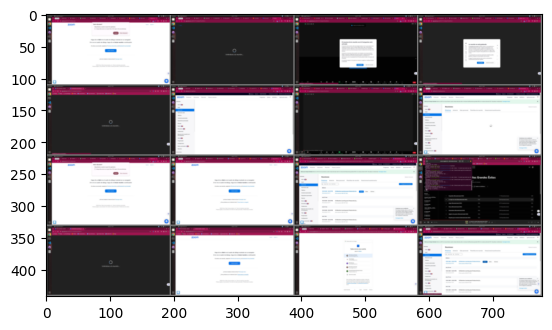

In [66]:
import numpy as np 
import matplotlib.pyplot as plt 

def imshow(img):
    img = img*0.5 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images = next(dataiter)
imshow(torchvision.utils.make_grid(images, nrow = 4))


In [45]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,4, stride=2, padding="valid")
        self.conv2 = nn.Conv2d(32,64,4, stride=2, padding="valid")
        self.conv3 = nn.Conv2d(64,128,4, stride=2, padding="valid")
        self.conv4 = nn.Conv2d(128,256,4, stride=2, padding="valid")
        self.fc_mean = nn.Linear(256*H*W, latent_dims)
        self.fc_logvar = nn.Linear(256*H*W, latent_dims)

        self.N = torch.distributions.normal.Normal(torch.tensor(0.0).to(device), 
                                                   torch.tensor(1.0).to(device=device))
        self.kl = 0
        
        encoder_inputs = keras.Input(shape=(64, 64, 3))
        x = layers.Conv2D(32, 4, activation="relu", strides=2, padding="valid")(encoder_inputs)
        x = layers.Conv2D(64, 4, activation="relu", strides=2, padding="valid")(x)
        x = layers.Conv2D(128, 4, activation="relu", strides=2, padding="valid")(x)
        x = layers.Conv2D(256, 4, activation="relu", strides=2, padding="valid")(x)
        x = layers.Flatten()(x)
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling(name="z_sample")([z_mean, z_log_var])
        return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1)
        z_mu = self.fc_mean(x)
        z_logvar = self.fc_logvar(x)
        z_sigma = torch.exp(z_logvar)
        
        z = z_mu + z_sigma*self.N.sample(z_mu.shape)
        self.kl = (sigma**2 + z_mu**2 - z_logvar - 1/2).sum()
        return z, 

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3*3*32),
            nn.ReLU(True),
            nn.Unflatten(1,(32,3,3)),
            nn.ConvTranspose2d(32,16,3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16,8,3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8,1,3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

class Vae(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

192.0